# Springboard - Data Science Career Track

## Capstone Project II: Book Recommendations - goodreads.com

Data: https://github.com/zygmuntz/goodbooks-10k

This dataset contains six million ratings for ten thousand most popular (with most ratings) books. There are also:

- books marked to read by the users
- book metadata (author, year, etc.)
- tags/shelves/genres

**Goal of the project: Recommend books to Goodreads.com users**

**Table of contents:**

[1) Data Inspection and Cleaning](#data_cleaning)

[2) Exploratory Data Analysis](#eda)

[3) Recommendation system](#recommender)


**API Key**

In [1]:
KEY = '0X3crFDSjHUTEHDPOlaFCg'
SECRET = 'ZAxgfS7OnTBnMCzRpwKEwao2TzjZEzO3cVVTWL9W8'

#### Libraries

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
sns.set()

from collections import Counter
from itertools import compress
from goodreads import client
from scipy.stats import normaltest, shapiro

from bokeh.io import output_notebook
output_notebook()
from bokeh.io import output_file, show
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import CategoricalColorMapper, Slider, HoverTool, Select
from bokeh.layouts import column, widgetbox

from tqdm import tqdm


Loading BokehJS ...

## 1) Data inspection and Cleaning
<a id="data_cleaning"></a>

### 1.1) Tags

***book_tags.csv*** contains tags/shelves/genres assigned by users to books. Tags in this file are represented by their IDs. They are sorted by goodreads_book_id ascending and count descending.

In [3]:
# book_tags
book_tags = pd.read_csv('book_tags.csv')
book_tags.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


***tags.csv*** translates tag IDs to names.

In [4]:
# tags
tags = pd.read_csv('tags.csv')
tags.head()

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


Let's join these two tables: **tags_df**

In [5]:
# tags_df
tags_df = pd.merge(book_tags, tags, on='tag_id').sort_values('count', ascending=False).reset_index(drop=True)
tags_df

,goodreads_book_id,tag_id,count,tag_name
0,865,30574,596234,to-read
1,2429135,30574,586235,to-read
2,18143977,30574,505884,to-read
3,3,30574,496107,to-read
4,24280,30574,488469,to-read
5,11235712,30574,474954,to-read
6,168668,30574,465640,to-read
7,18405,30574,454565,to-read
8,4981,30574,443942,to-read
9,930,30574,436097,to-read


I don't understand what the last 6 negative values represent in the 'count' column, so I'm going to disconsider them

In [6]:
# disconsider count negative rows
tags_df = tags_df[:-6]
tags_df.tail()

,goodreads_book_id,tag_id,count,tag_name
999901,327246,5141,1,books-for-creators-and-artists
999902,327242,5141,1,books-for-creators-and-artists
999903,327242,22343,1,on-my-bookself-irl
999904,320700,28881,1,sub
999905,327242,32111,1,want-to-read-i-have


In [7]:
# info
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999906 entries, 0 to 999905
Data columns (total 4 columns):
goodreads_book_id    999906 non-null int64
tag_id               999906 non-null int64
count                999906 non-null int64
tag_name             999906 non-null object
dtypes: int64(3), object(1)
memory usage: 30.5+ MB


In [8]:
# number of unique tags
assert len(tags_df.tag_id.unique()) == len(tags_df.tag_name.unique())

len(tags_df.tag_name.unique())

34250

In [9]:
# most common tags
tags_df.tag_name.value_counts().head(10)

to-read              9983
favorites            9881
owned                9858
books-i-own          9799
currently-reading    9776
library              9415
owned-books          9221
fiction              9097
to-buy               8692
kindle               8316
Name: tag_name, dtype: int64

### 1.2) Ratings

***ratings.csv*** contains almost 6 million book ratings by users. Ratings can go from one to five stars, where:

 - **5 stars**: "it was amazing"
 - **4 stars**: "really liked it"
 - **3 stars**: "liked it"
 - **2 stars**: "it was ok"
 - **1 star**: "did not like it"
 


In [10]:
# ratings
ratings = pd.read_csv('ratings.csv')
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [11]:
# info
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
user_id    int64
book_id    int64
rating     int64
dtypes: int64(3)
memory usage: 136.8 MB


In [12]:
# number of books
len(ratings.book_id.unique())

10000

In [13]:
# number of unique users
len(ratings.user_id.unique())

53424

In [14]:
# check if there are book ratings duplications by users
ratings[ratings[['user_id', 'book_id']].duplicated()]

,user_id,book_id,rating


### 1.3) to read

***to_read.csv*** provides IDs of the books marked "to read" by each user.

In [15]:
# to_read
to_read = pd.read_csv('to_read.csv')
to_read.head()

,user_id,book_id
0,9,8
1,15,398
2,15,275
3,37,7173
4,34,380


In [16]:
# to_read info
to_read.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912705 entries, 0 to 912704
Data columns (total 2 columns):
user_id    912705 non-null int64
book_id    912705 non-null int64
dtypes: int64(2)
memory usage: 13.9 MB


### 1.4) books

***books.csv*** has metadata for each book (goodreads IDs, authors, title, average rating, etc.). 

**goodreads IDs**:
    
Each book may have many editions. **goodreads_book_id** and **best_book_id** generally point to the most popular edition of a given book, while goodreads **work_id** refers to the book in the abstract sense.

It's possible to use the goodreads book and work IDs to create URLs as follows:

- https://www.goodreads.com/book/show/17397466
- https://www.goodreads.com/work/editions/24219959

Note that **book_id** in *ratings.csv* and *to_read.csv* maps to **work_id**, not to goodreads_book_id, **meaning that ratings for different editions are aggregated**.

In [17]:
# books
books = pd.read_csv('books.csv')
books.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


'books_count' is the number of editions for a given work. I'll change this name, for clarity, to **book_editions**:

In [18]:
# renaming the number of editions column
books = books.rename({'books_count': 'book_editions'}, axis=1)

In [19]:
# books info
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
book_id                      10000 non-null int64
goodreads_book_id            10000 non-null int64
best_book_id                 10000 non-null int64
work_id                      10000 non-null int64
book_editions                10000 non-null int64
isbn                         9300 non-null object
isbn13                       9415 non-null float64
authors                      10000 non-null object
original_publication_year    9979 non-null float64
original_title               9415 non-null object
title                        10000 non-null object
language_code                8916 non-null object
average_rating               10000 non-null float64
ratings_count                10000 non-null int64
work_ratings_count           10000 non-null int64
work_text_reviews_count      10000 non-null int64
ratings_1                    10000 non-null int64
ratings_2                    10000 n

 - **book_id, goodreads_book_id, best_book_id, and work_id** seem ok.

In [20]:
len(books.work_id.unique())

10000

In [21]:
# number of unique work_id's
len(books.work_id.unique()) == len(books.goodreads_book_id.unique())

True

 - There are some rows where the **isbn** and **isbn13** number are missing, but for now we will leave it like that and return later if necessary.

In [22]:
# where isbn miss
books[books['isbn'].isna()].head()

,book_id,goodreads_book_id,best_book_id,work_id,book_editions,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
105,106,9418327,9418327,14302659,48,NaN,NaN,Tina Fey,2011.0,Bossypants,...,506250,609260,35142,14842,31761,129390,230080,203187,https://images.gr-assets.com/books/1481509554m...,https://images.gr-assets.com/books/1481509554s...
120,121,7604,7604,1268631,370,NaN,NaN,"Vladimir Nabokov, Craig Raine",1955.0,Lolita,...,469836,517990,18107,21091,37205,108664,165477,185553,https://images.gr-assets.com/books/1377756377m...,https://images.gr-assets.com/books/1377756377s...
161,162,49552,49552,3324344,675,NaN,NaN,"Albert Camus, Matthew Ward",1942.0,L’Étranger,...,420600,483623,14836,10563,28920,100140,174957,169043,https://images.gr-assets.com/books/1349927872m...,https://images.gr-assets.com/books/1349927872s...
187,188,10664113,10664113,2936175,115,NaN,NaN,George R.R. Martin,2011.0,A Dance with Dragons,...,365954,424618,20072,2399,10150,53744,147136,211189,https://images.gr-assets.com/books/1327885335m...,https://images.gr-assets.com/books/1327885335s...
202,203,11505797,11505797,16441531,85,NaN,NaN,Jamie McGuire,2011.0,Beautiful Disaster,...,418309,442696,25298,17185,23298,61993,115123,225097,https://images.gr-assets.com/books/1358259032m...,https://images.gr-assets.com/books/1358259032s...


- **Authors**

In [23]:
# number of unique authors
len(books.authors.unique())

4664

- **Original publication year** - there are 21 missing values, but for now I will leave it like that.

In [24]:
# original_publication_year missing values
books['original_publication_year'].isna().sum()

21

- The same with **original_title**

In [ ]:
# - The same with **original_title** missing values
books['original_title'].isna().sum()

585

- **Title**

In [ ]:
# number of unique titles
len(books.title.unique())

9964

In [ ]:
# titles that are not unique
print(books.title.value_counts()[:len([i for i in books.title.value_counts() if i > 1])])

print("\nNumber of not unique titles: {}".format(len([i for i in books.title.value_counts() if i > 1])))

Selected Poems                               4
Stone Soup                                   3
The Collected Poems                          2
The Complete Stories and Poems               2
Monster                                      2
Sisters                                      2
Perfect                                      2
Private (Private, #1)                        2
'Salem's Lot                                 2
The Complete Poems                           2
Leviathan                                    2
The Witness                                  2
One Flew Over the Cuckoo's Nest              2
The Island                                   2
Are You My Mother?                           2
Between the Lines (Between the Lines, #1)    2
Anatomy for the Artist                       2
The Gift                                     2
The List                                     2
The Collector                                2
Arcadia                                      2
Invisible    

In [ ]:
# not unique titles
titles_not_uniq = books.title.value_counts()[:len([i for i in books.title.value_counts() if i > 1])].index

# check lines
check_titles = books[books.title.isin(titles_not_uniq)]

# number of them
print("Number of rows with non-unique titles: {}".format(check_titles.shape[0]))

# number of different authors
print("Number of different authors: {}".format(len(check_titles.authors.unique())))


Number of rows with non-unique titles: 69
Number of different authors: 66


In [ ]:
# which 3 authors repeat?
repeat_auth = check_titles.authors.value_counts()[:3].index

# check again
books[(books.title.isin(titles_not_uniq)) & (books.authors.isin(repeat_auth))].iloc[:, :15]


,book_id,goodreads_book_id,best_book_id,work_id,book_editions,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count
2371,2372,12716613,12716613,17851429,75,399159371,9.780399e+12,Nora Roberts,2012.0,The Witness,The Witness,NaN,4.19,40943,49415
5173,5174,18668066,18668066,26493730,52,399171088,9.780399e+12,Nora Roberts,2014.0,The Collector,The Collector,eng,3.92,15888,22703
7024,7025,26506,26506,1008958,52,385340222,9.780385e+12,Danielle Steel,2007.0,Sisters,Sisters,eng,3.81,13621,14641
7448,7449,6345193,6345193,6448995,44,805090800,9.780805e+12,Paul Auster,2009.0,Invisible,Invisible,eng,3.71,11706,13897
7461,7462,456,456,1128381,50,140178139,9.780140e+12,Paul Auster,1992.0,Leviathan,Leviathan,eng,3.95,10002,11794
7683,7684,59836,59836,1912773,55,440221315,9.780440e+12,Danielle Steel,1986.0,The Gift,The Gift,en-US,3.91,12382,13114


When comparing the title and author columns on these cases we see there is nothing wrong with the data. They just wrote a book with the same title than other author did, and not twice as we can see.

- **language_code** - everything seems to be ok. Regarding the missing values, I will leave it like that for now.

In [ ]:
# different languages
books.language_code.value_counts()

eng      6341
en-US    2070
en-GB     257
ara        64
en-CA      58
fre        25
ind        21
spa        20
ger        13
per         7
jpn         7
por         6
pol         6
en          4
dan         3
nor         3
ita         2
fil         2
swe         1
vie         1
mul         1
rus         1
rum         1
tur         1
nl          1
Name: language_code, dtype: int64

In [ ]:
# missing values
books[books.language_code.isna()].head()

,book_id,goodreads_book_id,best_book_id,work_id,book_editions,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
44,45,4214,4214,1392700,264,770430074,9.780770e+12,Yann Martel,2001.0,Life of Pi,...,1003228,1077431,42962,39768,74331,218702,384164,360466,https://images.gr-assets.com/books/1320562005m...,https://images.gr-assets.com/books/1320562005s...
131,132,3431,3431,2561472,123,1401308589,9.781401e+12,Mitch Albom,2003.0,The Five People You Meet in Heaven,...,449501,474699,16682,12360,33669,107800,155830,165040,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
203,204,5326,5326,3097440,2380,1561797464,9.781562e+12,Charles Dickens,1843.0,A Christmas Carol,...,394540,441396,11568,6737,21415,93906,153823,165515,https://images.gr-assets.com/books/1406512317m...,https://images.gr-assets.com/books/1406512317s...
236,237,10592,10592,1552134,249,1416524304,9.781417e+12,Stephen King,1974.0,Carrie,...,356814,377650,8264,4564,19479,96352,136054,121201,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
287,288,19691,19691,1112006,117,425172902,9.780425e+12,Tom Clancy,1984.0,The Hunt for Red October,...,270318,278255,2117,9470,13707,49906,95296,109876,https://images.gr-assets.com/books/1281995542m...,https://images.gr-assets.com/books/1281995542s...


- **average_rating** seems ok.

In [ ]:
# average rating of all books
books['average_rating'].mean()

4.002191000000001

In [ ]:
# number of ratings in all books
books.work_ratings_count.sum()

596873216

- **ratings_count** or **work_ratings_count**

In [ ]:
# question
books[['ratings_count', 'work_ratings_count', 'work_text_reviews_count', 'ratings_1' ,'ratings_2' ,'ratings_3',
       'ratings_4' ,'ratings_5']].head()

,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
0,4780653,4942365,155254,66715,127936,560092,1481305,2706317
1,4602479,4800065,75867,75504,101676,455024,1156318,3011543
2,3866839,3916824,95009,456191,436802,793319,875073,1355439
3,3198671,3340896,72586,60427,117415,446835,1001952,1714267
4,2683664,2773745,51992,86236,197621,606158,936012,947718


In [ ]:
# check work_ratings_count
(np.sum(books[['ratings_1' ,'ratings_2' ,'ratings_3', 'ratings_4' ,'ratings_5']], axis=1) == 
 books['work_ratings_count']).sum()

10000

In [ ]:
# check ratings_count
(np.sum(books[['ratings_1' ,'ratings_2' ,'ratings_3', 'ratings_4' ,'ratings_5']], axis=1) == 
 books['ratings_count']).sum()

14

It is the column **work_ratings_count** that corresponds to the total number of ratings per row/book.

- The columns representing the **ratings** from 1 to 5 seem ok, as **work_text_reviews_count** do.

- Finally, the last two columns - **image_url** and **small_image_url** - represent the image of the cover of the book. 

#### Access GoodReads API using the Goodreads package

In [ ]:
from goodreads import client
gc = client.GoodreadsClient(KEY, SECRET)

**+ Book description**

- I will add a column in the books data frame regarding the **description** of each book, using the API: 

*Note: I did this separately in another notebook, and I will from now on use the file 'books_new.csv' instead of 'books.csv'*

In [ ]:
%%script false 

# create empty series
books['description'] = np.empty

# adding the book description - text column
for i in range(len(books)):
    try:
        books['description'][i] = gc.book(books['goodreads_book_id'][i]).description
    except:
        None

# save to a new file, named books_new
books.to_csv('books_new.csv')

Couldn't find program: 'false'


In [ ]:
# new dataframe, with the column 'description' added
books_new = pd.read_csv('books_new.csv').drop('Unnamed: 0', axis=1)
books_new.head(3)

,book_id,goodreads_book_id,best_book_id,work_id,book_editions,isbn,isbn13,authors,original_publication_year,original_title,...,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,description,popular_shelves
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,"Could you survive on your own, in the wild, wi...","[to-read, favorites, currently-reading, young-..."
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,Harry Potter's life is miserable. His parents ...,"[to-read, currently-reading, fantasy, favorite..."
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,<b>About three things I was absolutely positiv...,"[to-read, currently-reading, young-adult, fant..."


In [ ]:
# see column 'description'
books_new['description'].describe()

count                          9986
unique                         2375
top       <built-in function empty>
freq                           7612
Name: description, dtype: object

There are 14 missing book descriptions.

In [ ]:
# example of book description
books_new['description'][0]

"Could you survive on your own, in the wild, with everyone out to make sure you don't live to see the morning?<br /><br />In the ruins of a place once known as North America lies the nation of Panem, a shining Capitol surrounded by twelve outlying districts. The Capitol is harsh and cruel and keeps the districts in line by forcing them all to send one boy and one girl between the ages of twelve and eighteen to participate in the annual Hunger Games, a fight to the death on live TV. Sixteen-year-old Katniss Everdeen, who lives alone with her mother and younger sister, regards it as a death sentence when she is forced to represent her district in the Games. But Katniss has been close to dead before - and survival, for her, is second nature. Without really meaning to, she becomes a contender. But if she is to win, she will have to start making choices that weigh survival against humanity and life against love.<br /><br />New York Times bestselling author Suzanne Collins delivers equal par

**+ Popular shelves**

- I will also add the **most popular shelves** the book is in, also using the Goodreads API

In [ ]:
%%script false 

# create empty series
books['popular_shelves'] = np.empty

# adding the most popular shelves - text column
for i in range(len(books)):
    try:
        books['popular_shelves'][i] = gc.book(books['goodreads_book_id'][i]).popular_shelves
    except:
        None

# save to the new file, named books_new - we can overwrite
books.to_csv('books_new.csv')

Couldn't find program: 'false'


In [ ]:
# new dataframe, with the column 'popular_shelves' added
books_new = pd.read_csv('books_new.csv').drop('Unnamed: 0', axis=1)
books_new.head(3)

,book_id,goodreads_book_id,best_book_id,work_id,book_editions,isbn,isbn13,authors,original_publication_year,original_title,...,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,description,popular_shelves
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,"Could you survive on your own, in the wild, wi...","[to-read, favorites, currently-reading, young-..."
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,Harry Potter's life is miserable. His parents ...,"[to-read, currently-reading, fantasy, favorite..."
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,<b>About three things I was absolutely positiv...,"[to-read, currently-reading, young-adult, fant..."


In [ ]:
# see column 'popular_shelves'
books_new['popular_shelves'].describe()

count                         10000
unique                         8969
top       <built-in function empty>
freq                           1030
Name: popular_shelves, dtype: object

In [ ]:
# example of popular shelves of a book
books_new['popular_shelves'][0]

'[to-read, favorites, currently-reading, young-adult, fiction, dystopian, ya, fantasy, dystopia, science-fiction, books-i-own, sci-fi, owned, series, favourites, romance, adventure, hunger-games, owned-books, book-club, kindle, teen, my-books, post-apocalyptic, the-hunger-games, favorite-books, read-in-2012, re-read, action, all-time-favorites, suzanne-collins, ya-fiction, 5-stars, books, sci-fi-fantasy, favorite, scifi, survival, audiobook, novels, ebook, i-own, audiobooks, young-adult-fiction, read-in-2011, thriller, my-favorites, default, library, ebooks, fantasy-sci-fi, reread, read-2012, faves, futuristic, my-library, suspense, audio, read-in-2010, shelfari-favorites, ya-books, ya-lit, favs, finished, teen-fiction, favorite-series, own-it, distopia, action-adventure, love-triangle, love, english, dystopian-fiction, coming-of-age, distopian, ya-fantasy, loved, novel, read-more-than-once, read-in-2013, borrowed, on-my-shelf, ya-dystopian, scifi-fantasy, favourite, bookshelf, to-buy,

## 2) Exploratory Data Analysis
<a id="eda"></a>

### **Tags**

In [ ]:
# Exploring tags
tags_df.head()

,goodreads_book_id,tag_id,count,tag_name
0,865,30574,596234,to-read
1,2429135,30574,586235,to-read
2,18143977,30574,505884,to-read
3,3,30574,496107,to-read
4,24280,30574,488469,to-read


### - **What are the most common tags?**

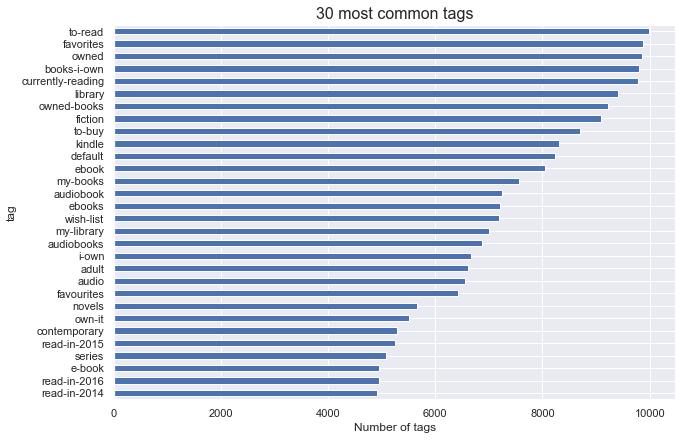

In [ ]:
n = 30

# most tagged names
tags_df['tag_name'].value_counts(ascending=True)[-n:].plot(kind='barh')

plt.title("{} most common tags".format(n), fontsize=16)
plt.xlabel("Number of tags")
plt.ylabel("tag")

plt.subplots_adjust(left=0, bottom=-0.3, right=1.3, top=1, wspace=0, hspace=0)
plt.show()

Although "to-read" appears at the top of the list, some tags that have the same meaning easily surpass it when aggregated. For example, "owned", "books-i-own", owned-books" and "my-books" means the same.

### - What are the most common genres? 

Let us take a look at the main genres. To do that I picked a list with genres from the web and added some relevant names. I will base the analysis on tag names.

In [ ]:
# list of genres taken from the web, plus others added manually. Added the '-'
genres = ["Art", "Adventure", "Biography", "Business", "Chick-Lit", "Children", "Christian", "Classics", "Comics", 
          "Contemporary", "Cookbook", "Crime", "Fantasy", "Fiction", "Gay-and-Lesbian", "Graphic-Novels",
          "Historical-Fiction", "Health", "History", "Horror", "Humor", "Comedy", "Manga", "Math", "Memoir", "Music", 
          "Mystery", "New-Age", "Nonfiction", "Paranormal", "Philosophy", "Poetry", "Psychology", "Religion", "Romance",
          "Science", "Science-Fiction", "sci-fi-fantasy", "Self-Help", "Suspense", "Spirituality", "Sports", "Thriller", 
          "Travel", "Young-Adult", 
          
          # add
          "adult", "novels", "action", "supernatural", "funny", "mystery-suspense", 
         "autobiography", "murder", "murder-mystery", "paranormal-fantasy", "spiritual", "satire", "short-story",
         "picture", "political-thriller", "fairytale", "drama", "alternate-history", "graphic-novel",
         "encyclopedia", "guide", 
          
          # add plural/singular
          "arts", "adventures", "biographies", "classic", "crimes", "maths", "memoirs", "religions", "romances", 
          "sciences", "sport", "thrillers", "travels",
         "adults", "novel", "murders", "guides"]    

# take lowercase
genres = [i.lower() for i in genres]

# build dataframe
genres_df = pd.DataFrame({
                'genre': genres,
                'nr': [tags_df['tag_name'].value_counts().loc[genres[i]] for i in range(len(genres))]}).sort_values(
    'nr', ascending=True).reset_index(drop=True)

In [ ]:
# join genres with the same meaning
genre_singular = ["art", "adventure", "biography", "classic", "crime", "math", "memoir", "religion",  
                 "romance", "science", "sport", "thriller", "travel", "adult", "novel", "murder", "guide"]

genre_plural = ["arts", "adventures", "biographies", "classics", "crimes", "maths", "memoirs", "religions",  
                "romances", "sciences", "sports", "thrillers", "travels", "adults", "novels", "murders", "guides"]

# sum and drop the unnecessary rows
for i, j in zip(genre_singular, genre_plural):
    # sum
    genres_df.loc[genres_df['genre'] == i, 'nr'] = genres_df[genres_df['genre'] == i]['nr'].iloc[0] + \
                                                   genres_df[genres_df['genre'] == j]['nr'].iloc[0]
    # drop the plural
    genres_df.drop(genres_df.index[genres_df[genres_df['genre'] == j].index], inplace=True)
    genres_df.reset_index(inplace=True, drop=True)    

In [ ]:
# reorder
genres_df = genres_df.sort_values('nr', ascending=True)

# genres df
genres_df.head()

,genre,nr
0,encyclopedia,3
1,gay-and-lesbian,7
2,guide,35
4,new-age,63
3,math,67


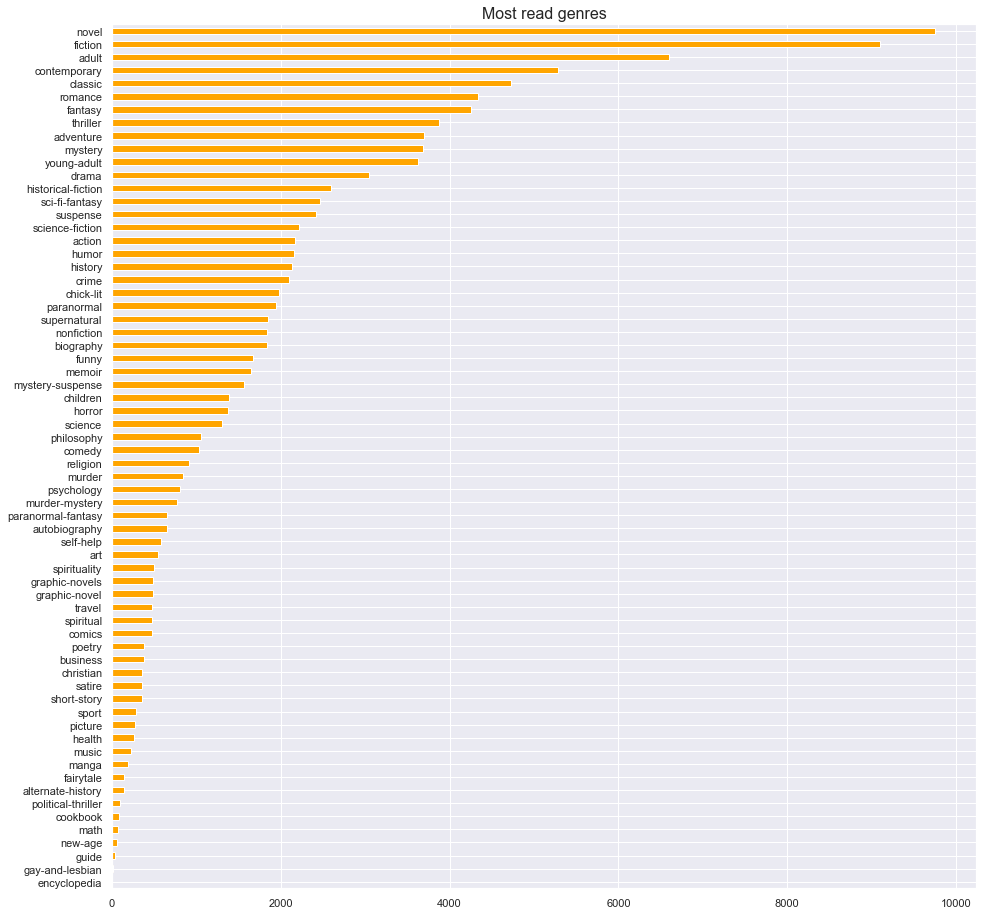

In [ ]:
# barplot
genres_df['nr'].plot(kind='barh', color='orange')

plt.title("Most read genres", fontsize=16)
plt.yticks(np.arange(0, len(genres_df)), genres_df['genre'])

plt.subplots_adjust(left=0, bottom=-2, right=2, top=1, wspace=0, hspace=0)
plt.show()

It seems that fiction books, mainly of the genre "adult", "novel"/"romance", "contemporary" and "fantasy" are amongst the most read genres by users.

### **Ratings**

In [ ]:
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


### - **How are ratings distributed? Do people tend to give higher or lower ratings?**

In [ ]:
# count ratings
ratings['rating'].value_counts().sort_index(ascending=False)

5    1983093
4    2139018
3    1370916
2     359257
1     124195
Name: rating, dtype: int64

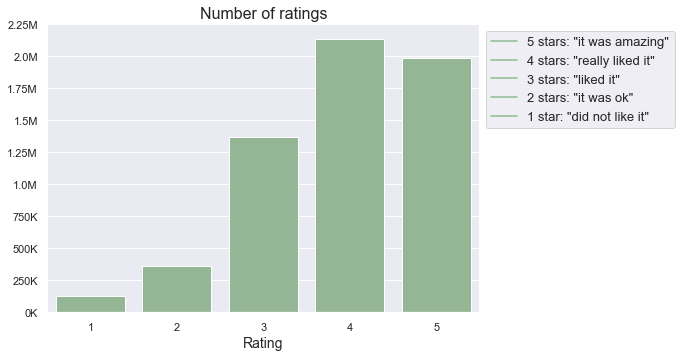

In [ ]:
# count ratings
sns.countplot(x='rating', data=ratings, color='darkseagreen')

plt.title("Number of ratings", fontsize=16)
plt.xlabel("Rating", fontsize=14)
plt.ylabel("", fontsize=14)

# defining legend 
one = mlines.Line2D([], [], color='darkseagreen', label='1 star: "did not like it"')
two = mlines.Line2D([], [], color='darkseagreen', label='2 stars: "it was ok"')
three = mlines.Line2D([], [], color='darkseagreen', label='3 stars: "liked it"')
four = mlines.Line2D([], [], color='darkseagreen', label='4 stars: "really liked it"')
five = mlines.Line2D([], [], color='darkseagreen', label='5 stars: "it was amazing"')
plt.legend(handles=[five, four, three, two, one], bbox_to_anchor=(1, 1), fontsize=13)

plt.yticks(np.arange(0, 2500000, 250000), 
           ["{}K".format(250*i) for i in range(4)] + ["{}M".format(1+i*0.25) for i in range(0, 6)])

plt.subplots_adjust(left=0, bottom=-0, right=1, top=1, wspace=0, hspace=0)
plt.show()

In [ ]:
# percentage of 4 and 5 stars
print("4 and 5 stars percentage: {}".format(ratings['rating'].isin([4, 5]).sum() / len(ratings)))
print("3, 4 and 5 stars percentage: {}".format(ratings['rating'].isin([3, 4, 5]).sum() / len(ratings)))

4 and 5 stars percentage: 0.6897223264734972
3, 4 and 5 stars percentage: 0.9191075547994061


In [ ]:
# average rating
print("Ratings mean: {}".format(round(ratings['rating'].mean(), 1)))
print("Ratings median: {}".format(round(ratings['rating'].median(), 1)))

Ratings mean: 3.9
Ratings median: 4.0


Regarding our users data set, we see that **almost 70%** of the ratings are classified as either **"it was amazing"** (5 stars) or **"really liked it"** (4 stars). We can say that in general users give good ratings. This is not surprising since this is a data set for only popular books and, among other reasons, the users are the ones who choose the books they are going to read and the topics they are going to pursue, according to their interests. If you add a **"liked it"** rating (3 stars), the percentage goes up to **91%**.

The average rating is in fact 3.9, nearly close to a "really liked it" evaluation, which is very close to the mean of all books (596873216) data frame as we've seen above (4.002191000000001). The median is 4.

### - How is the distribution of ratings by genre? 

Let us look at the most famous genres:

In [ ]:
# top genres
n = 10

top_genres = list(genres_df.sort_values('nr', ascending=False)['genre'][:n])
print(top_genres)

['novel', 'fiction', 'adult', 'contemporary', 'classic', 'romance', 'fantasy', 'thriller', 'adventure', 'mystery']


As said before, book_id in ratings.csv maps to work_id, not to goodreads_book_id. I will then create a new dataframe.

In [ ]:
# %%script false

# new dataframe
ratings_genres = ratings.copy()
ratings_genres['goodreads_book_id'] = [books_new[books_new['work_id'] == i].goodreads_book_id for i in ratings['book_id']]

# replace the genre names
for i, j in zip(genre_singular, genre_plural):
    tags_df.loc[tags_df['tag_name'] == j, 'tag_name'] = i
    
ratings_genres['genre'] = [tags_df[tags_df['goodreads_book_id'] == i].tag_name for i in ratings_genres['goodreads_book_id']]

# save to the new file, named ratings_genres
ratings_genres.to_csv('ratings_genres.csv')

In [ ]:
# load new dataframe
ratings_genres = pd.read_csv('ratings_genres.csv')
ratings_genres.head()

In [ ]:
ratings.head()

### - **Does the distribution of the number of ratings given follow a normal distribution?**

In [ ]:
# number of users
print("Number of users: {}".format(len(ratings['user_id'].unique())))

In [ ]:
# user's number of ratings given distribution

list_ratings = list(ratings['user_id'].value_counts())

# histogram
sns.distplot(list_ratings)

plt.title("Histogram: Number of ratings per user", fontsize=16)
plt.xlabel("Number of ratings")
plt.ylabel("Probability Density Function")

plt.subplots_adjust(left=0, bottom=-0, right=1, top=1, wspace=0, hspace=0)
plt.show()

The Kernel Density Estimate which can be seen in the plot above does not suggest that, but we will check with a normality test: D'Agostino's K-squared test. The null hypothesis assumes normality of the distribution.

In [ ]:
# D'Agostino's K-squared test
stat, p_value = normaltest(list_ratings)

print("D'Agostino's K-squared test: statistic=%.3f; p-value=%.3f" % (stat, p_value))

Since the p-value is practically zero, we have the statistical evidence to **reject** the hypothesis that the number of ratings given follows a normal distribution. Looking at the distribution, we see that it is somewhat **left-skewed**.

### - **Can we have a 95% confidence interval for the mean of the ratings an user gives?**

I'll assume that the data is representative of the population. The diversity in book genre is pretty widespread and users that rate the most popular books and have this many ratings given on average is good enough.

We can make for now some inferences about the population of Goodreads users using the data in 'ratings.csv' (6 million ratings) - it may be useful when making recommendations later.

The conditions for assuming the Central Limit Theorem implications are met here, since:

 - the sample is more or less symmetric and bigger than 30, the value normally assumed for the validity of the Central Limit Theorem.
 - there was no replacement when retrieving the sample, but the observations are considered to be independent, since they constitute less than 10% of the population size (the 10% rule).
 - the sample was taken randomly (I assumed that it was).

In [ ]:
# create a bootstrap confidence interval for the mean

# bootstrap replica function
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

# Generate *size* bootstrap replicates function
def draw_bs_reps(data, func, size=1):
    return np.array([bootstrap_replicate_1d(data, func) for i in range(size)])


# 10000 bootstrap replicas of the mean
bs_replicates = draw_bs_reps(list_ratings, np.mean, 10000)

# (Bootstrap) 95% Confidence interval - we apply the Central Limit Theorem
conf_int = np.percentile(bs_replicates, [2.5, 97.5])
conf_int

In [ ]:
# observed mean
np.mean(list_ratings)

This is a pretty close range. **If we repeated measurements over and over again, 95% of the observed values for the mean of the number of ratings given by users would be very close to 112**.

In [ ]:
# histogram
sns.distplot(bs_replicates)

plt.title("Bootstrap replicas of the mean of the number of ratings given", fontsize=16)
plt.xlabel("Mean Number of ratings given")
plt.ylabel("Probability Density Function")

plt.subplots_adjust(left=0, bottom=-0, right=1, top=1, wspace=0, hspace=0)
plt.show()

In [ ]:
# Standard error of the mean (SEM) - from the bootstrap replicates
np.std(bs_replicates)

In [ ]:
# Standard error of the mean (SEM) - known expression
np.std(list_ratings) / np.sqrt(len(list_ratings))

### - **Do DISTRIBUTIONS of ratings among users vary significantly?**

In [ ]:
# Here is a sample of distributions among some random users

n = 30
sample_users = np.random.choice(ratings['user_id'].unique(), size=n, replace=False)

print("For a sample of {} users:".format(n))

for i, j in enumerate(sample_users):
    row = n / 5 # want 5 plots per row
    plt.subplot(row, 5, i+1)
    sns.countplot(ratings[ratings['user_id'] == j].rating, color='darkblue')
    plt.title("user {}".format(sample_users[i]))
    
plt.subplots_adjust(left=0, bottom=-2.5, right=3, top=1, wspace=0.25, hspace=0.5)
plt.show()


It is straightforward to see that the distributions of ratings vary significantly among users. We can see right away that the average rating by users are also significantly different.

### - **How does the AVERAGE rating given by a user evolves as the number of his/her number of given ratings increases, on average? Do people tend to become more critic and give lower ratings?**

I will first create a new data frame with user_id, number of ratings given and average rating.

In [ ]:
%%script false 

# create dataframe with user_id, number of ratings given and average rating
user_ratings = pd.DataFrame({'user_id': ratings['user_id'].value_counts().index, 
     'number_ratings': ratings['user_id'].value_counts(),
     'avg_rating': [ratings[ratings['user_id'] == i].rating.mean() for i in ratings['user_id'].value_counts().index]})

# save to disk
user_ratings.to_csv('user_ratings.csv')

In [ ]:
# load and check
user_ratings = pd.read_csv('user_ratings.csv').drop('Unnamed: 0', axis=1)
user_ratings.head()

In [ ]:
# relationship between number of ratings given and average rating
sns.lmplot('number_ratings', 'avg_rating', data=user_ratings)
plt.title("Relationship between number of ratings given and average rating")
plt.show()

In order to properly see the relationship I am going to agglomerate the users with the same number of given ratings and compute the average of their average rating given. Otherwise I would have almost 6 million points on the scatter plot as seen above. In any case, it's a negative relationship.

In [ ]:
# unique given number of ratings
nr_ratings = user_ratings['number_ratings'].unique()

# average of the average rating given 
avg_avg_rating = [user_ratings[user_ratings['number_ratings'] == i].avg_rating.mean() for i in nr_ratings]

# new dataframe
evolv_rating = pd.DataFrame({'nr_ratings': nr_ratings, 'avg_avg_rating': avg_avg_rating})

# scatter plot
sns.lmplot('nr_ratings', 'avg_avg_rating', data=evolv_rating, order=3, line_kws={'color': 'orange'}, 
          scatter_kws={'color': 'darkgreen'})

plt.title("User perspective: More ratings = more criticism?", fontsize=16)
plt.xlabel("Number of ratings given", fontsize=14)
plt.ylabel("Average rating", fontsize=14)

plt.subplots_adjust(left=0, bottom=0, right=1.2, top=1, wspace=0, hspace=0)
plt.show()


Each point encompasses a different number of users. As we have seen in the previous histogram, most of the data resides between 75 and 150 ratings given. In fact, almost 90%, as computed below. Curiously, we see here that up until 75 ratings given by a "user" the average rating tends to increase and probably the enthusiasm for books and reading as well. After that, and until 150, which is exactly the range where most of the data is, the average rating linearly decreases as the number of ratings increase. It then spreads across the range between 3.5 and 4.6 without a clear tendency.

**This may suggest that, on average, the user tends to become more critic and give lower ratings as it reads more books.**

In [ ]:
# percentile: 90% of the data regarding the number of ratings given is between
data_90 = np.percentile(list_ratings, [5, 95])
data_90

Taking now a closer look at the relevant range, we see more clearly this negative relationship:

In [ ]:
# see the relationship within the relevant range
new_nr_ratings = [i for i in nr_ratings if np.logical_and(i > data_90[0], i < data_90[1])]
new_avg_avg_rating = list(compress(avg_avg_rating, np.logical_and(nr_ratings > data_90[0], nr_ratings < data_90[1])))

# new dataframe
evolv_rating_2 = pd.DataFrame({'new_nr_ratings': new_nr_ratings, 'new_avg_avg_rating': new_avg_avg_rating})

# scatter plot
sns.lmplot('new_nr_ratings', 'new_avg_avg_rating', data=evolv_rating_2, order=1, line_kws={'color': 'blue'}, 
          scatter_kws={'color': 'darkgreen'})

plt.title("Zoom on the relevant range", fontsize=16)
plt.xlabel("Number of ratings given", fontsize=14)
plt.ylabel("Average rating", fontsize=14)

plt.subplots_adjust(left=0, bottom=-0, right=1.1, top=1, wspace=0, hspace=0)
plt.show()

In [ ]:
# Correlation coefficient
np.corrcoef(new_nr_ratings, new_avg_avg_rating)[0, 1]

There is a **very strong negative correlation** between the number of ratings a user has given and the average rating, suggesting, again, that the user tends to become less enthusiastic, on average, as he/she reads more books.

###  - **How does the distribution of ratings given by a user evolve as the number of ratings increases, on average?**

In [ ]:
# previously constructed data frame
user_ratings.head()

In [ ]:
# bokeh

# pick a spacely ordered group of different number of users (since they are ordered by ratings given in 'user_ratings')
n = 99
list_nr = user_ratings['user_id']  # they are by decreasing order of number of ratings given

# bokeh plot
def modify_doc(doc):
    n = len(list_nr)-1
    source = ColumnDataSource(
        data={'ratings': np.arange(1, 6),
            'counts': [ratings[ratings['user_id'] == list_nr[0]].rating.tolist().count(i) for i in np.arange(1, 6)]})
    
    # Create plots and widgets
    plot = figure(width=600, height=400)
    plot.vbar(x='ratings', top='counts', source=source, width=1)
    
    # Make a slider object: slider
    slider = Slider(start=0, end=n, step=1, value=0, title='Distribution of ratings')

    # Define the callback function: update_plot
    def update_plot(attr, old, new):
        
        # Set the nr name to slider.value and new_data to source.data
        nr = slider.value
        
        new_data = {'ratings': np.arange(1, 6),
            'counts': [ratings[ratings['user_id'] == list_nr[nr]].rating.tolist().count(i) for i in np.arange(1, 6)]}
        
        source.data = new_data
        
        # Add title to figure: plot.title.text
        plot.title.text = 'Ratings given by user {}: {}'.format(list_nr[nr], 
             np.sum([ratings[ratings['user_id'] == list_nr[nr]].rating.tolist().count(i) for i in np.arange(1, 6)]))


    # Attach the callback to the 'value' property of slider
    slider.on_change('value', update_plot)
    
    # Arrange plots and widgets in layouts
    layout = column(slider, plot)
    doc.add_root(layout)

show(modify_doc) 

As we can see, there is also a **tendency to make the distribution skewed to the right, as the number of given ratings increase**.

### - How does the average rating of a book relate to the number of ratings it has received?

In [ ]:
# lmplot
sns.lmplot('work_ratings_count', 'average_rating', data=books_new)

plt.title("Book perspective: Number of ratings received vs Average Rating", fontsize=16)
plt.xlabel("Number of ratings received", fontsize=14)
plt.ylabel("Average rating", fontsize=14)

plt.subplots_adjust(left=0, bottom=-0, right=1.1, top=1, wspace=0, hspace=0)
plt.show()

This shows us the **slight positive relationship between the number of ratings (or fame) a book has received and its average rating**.

In [ ]:
# Correlation coefficient
corr_coeff_observed = np.corrcoef(books_new['work_ratings_count'], books_new['average_rating'])[0, 1]
corr_coeff_observed

- Can we be sure this correlation is not by chance? To know that I will do a test of correlation.

**Hypothesis test:**
    
   - **Null hypothesis**: "the two variables are completely uncorrelated"
   - **Alternate hypothesis**: "the two variables are correlated"
   - **Test statistic**: "pearson correlation coefficient"    

In [ ]:
# pearson correlation definition
def pearson_corr_coeff(data_1, data_2):
    return np.corrcoef(data_1, data_2)[0, 1]

# 1 permutation formula
def permutation_sample(data1, data2):
    data = np.concatenate((data1, data2))
    permuted_data = np.random.permutation(data)
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]
    return perm_sample_1, perm_sample_2

# permutations of size n
def draw_perm_reps(data_1, data_2, func, size=1):
    perm_replicates = np.empty(size)

    for i in range(size):
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)
    return perm_replicates

######################################

# 10 000 permutations
permutations = draw_perm_reps(books_new['work_ratings_count'], books_new['average_rating'], pearson_corr_coeff, size=10000)

p_value = np.sum(permutations >= corr_coeff_observed) / len(permutations)

print("\np-value:", p_value)

We **reject the hypothesis that the two variables are not correlated**, considering a level of significance of 1%. As the number of ratings a book gets increases, the higher the chance that it will have a higher average rating. In any case, there is too much noise and the correlation is not clear.

### **Books**

In [ ]:
# books_new
books_new.columns

### - What are the most famous books?

In [ ]:
n = 20

# sorting by work_ratings_count
famous_books = books_new.sort_values('work_ratings_count', ascending=True).title[-n:]
famous_books_count_ratings = books_new.sort_values('work_ratings_count', ascending=True).work_ratings_count[-n:]

famous_books_count_ratings.plot(kind='barh')

plt.title("{} Most famous books".format(n), fontsize=16)
plt.xlabel("Number of ratings", fontsize=14)
plt.ylabel("Book", fontsize=14)
plt.yticks(np.arange(0, n), famous_books)

plt.subplots_adjust(left=0, bottom=-0.5, right=2, top=1, wspace=0, hspace=0)
plt.show()

### - What are the most beloved books?

In [ ]:
n = 20

# sorting by work_ratings_count
famous_books = books_new.sort_values('average_rating', ascending=True).title[-n:]
famous_books_avg_ratings = books_new.sort_values('average_rating', ascending=True).average_rating[-n:]

sns.barplot(famous_books, famous_books_avg_ratings, palette="Blues_d")

plt.title("{} Most beloved books".format(n), fontsize=16)
plt.xlabel("Book", fontsize=14)
plt.ylabel("Average rating", fontsize=14)
plt.xticks(rotation=90)
plt.axhline(y=famous_books_avg_ratings.max(), color='red', linestyle="--")
plt.annotate(famous_books_avg_ratings.iloc[-1], xy=(n-1.25, famous_books_avg_ratings.max()+0.1), va='center')

plt.subplots_adjust(left=0, bottom=-0.5, right=2, top=1, wspace=0, hspace=0)
plt.show()

### - What are the most read languages?

In [ ]:
# Considering the english language
plt.subplot(1, 2, 1)
books_new['language_code'].value_counts(ascending=True).plot(kind='barh')
plt.title("Most read languages", fontsize=16)
plt.xlabel("Number of books")
plt.ylabel("Language")

# not considering the english language
english_lang = ['eng', 'en-US', 'en-CA', 'en-GB', 'en', np.nan]
not_english = [i for i in Counter(books_new['language_code']).keys() if i not in english_lang]
not_english_read = [Counter(books_new['language_code'])[j] for j in not_english]

not_english_df = pd.DataFrame({'language': not_english, 'number': not_english_read}).sort_values(
                                'number').reset_index(drop=True)

plt.subplot(1, 2, 2)
not_english_df['number'].plot(kind='barh')

plt.title("Most read languages, excluding english", fontsize=16)
plt.xlabel("Number of books")
plt.ylabel("Language")
plt.yticks(np.arange(0, len(not_english_df)), not_english_df['language'])

plt.subplots_adjust(left=0, bottom=-0.5, right=2, top=1, wspace=0.3, hspace=0)
plt.show()

English is by far the most read language, and almost the only one in this data set, in relative terms.

### - Is having more authors better?

In [ ]:
# create column with number of authors (separated by comma)
books_new['nr_authors'] = [len(books_new.authors[i].split(',')) for i in range(len(books_new))]

# plot
sns.lmplot('nr_authors', 'average_rating', data=books_new)

plt.title("More authors = better rating?", fontsize=16)
plt.xlabel("Number of book authors", fontsize=14)
plt.ylabel("Average rating", fontsize=14)

plt.subplots_adjust(left=0, bottom=-0, right=1.1, top=1, wspace=0, hspace=0)
plt.show()

In [ ]:
# Correlation coefficient
corr_coeff_observed = np.corrcoef(books_new['nr_authors'], books_new['average_rating'])[0, 1]
corr_coeff_observed

Here the correlation is slightly more positive: **as the number of authors increases, so does the average rating**.

### - Does the length of the title influence the average rating?

In [ ]:
# new column with the length of the title
books_new['len_title'] = [len(books_new.title[i].split()) for i in range(len(books_new))]

# plot
sns.lmplot('len_title', 'average_rating', data=books_new)

plt.title("Title length vs Average Rating", fontsize=16)
plt.xlabel("Title: Number of words", fontsize=14)
plt.ylabel("Average rating", fontsize=14)

plt.subplots_adjust(left=0, bottom=-0, right=1.1, top=1, wspace=0, hspace=0)
plt.show()

In [ ]:
# Correlation coefficient
corr_coeff_observed = np.corrcoef(books_new['len_title'], books_new['average_rating'])[0, 1]
corr_coeff_observed

There is also a small positive correlation between the length of the title and the average rating.

## 3) Recommendation system
<a id="recommender"></a>